<a href="https://colab.research.google.com/github/OhadHayoun/Movies-system/blob/master/Collaborative_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install surprise

     |████████████████████████████████| 11.8MB 5.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618246 sha256=6aa6355d19aa42f5ef16dae823c103539cf6f838d95eb4d37973dd7bd496a585
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
! pip install matrix_factorization

     |████████████████████████████████| 22.2MB 1.6MB/s 
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-cp36-none-any.whl size=16468 sha256=ad0432373ef2ef42fdfd970d884b58777a64aeff6a1837467b4324c205b732fe
  Stored in directory: /root/.cache/pip/wheels/db/ef/99/19df32b6eb88678b0e3a42d2e24955e7753b2de44615111bad
Successfully built matrix-factorization
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from surprise import Reader, SVD, Dataset
from surprise.model_selection.validation import cross_validate
from matrix_factorization import KernelMF
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_movies.csv to cleaned_movies.csv
Saving ratings.csv to ratings.csv


# EDA and preprocessing

Preprocessing of the movie dataframe has been done in an other notebook. We downloaded here the final dataframe. We will keep rating only for movies that are in the cleaned dataframe. 

The number of ratings per user can vary a lot. However it can be very challenging to predict mivie ratings for users with few ratings. That why we will run our model with different minimum of rating per user and see the impacts on the metrics.

First let do a little EDA on the rating dataframe.

In [5]:
movies_df = pd.read_csv('cleaned_movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [6]:
movies_df.head(10)

,Unnamed: 0,budget,genres,id,imdb_id,original_title,production_companies,revenue,runtime,spoken_languages,title,vote_count,release_year,cast,keywords,director
0,0,30000000,"['Animation', 'Comedy', 'Family']",862,tt0114709,Toy Story,['Pixar Animation Studios'],373554033.0,81.0,['English'],Toy Story,5415.0,1995,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousy', 'toy', 'boy']",John Lasseter
1,1,65000000,"['Adventure', 'Fantasy', 'Family']",8844,tt0113497,Jumanji,"['TriStar Pictures', 'Teitler Film', 'Intersco...",262797249.0,104.0,"['English', 'Français']",Jumanji,2413.0,1995,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board game', 'disappearance', ""based on chil...",Joe Johnston
2,2,0,"['Romance', 'Comedy']",15602,tt0113228,Grumpier Old Men,"['Warner Bros.', 'Lancaster Gate']",0.0,101.0,['English'],Grumpier Old Men,92.0,1995,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fishing', 'best friend', 'duringcreditssting...",Howard Deutch
3,3,16000000,"['Comedy', 'Drama', 'Romance']",31357,tt0114885,Waiting to Exhale,['Twentieth Century Fox Film Corporation'],81452156.0,127.0,['English'],Waiting to Exhale,34.0,1995,"['Whitney Houston', 'Angela Bassett', 'Loretta...","['based on novel', 'interracial relationship',...",Forest Whitaker
4,4,0,['Comedy'],11862,tt0113041,Father of the Bride Part II,"['Sandollar Productions', 'Touchstone Pictures']",76578911.0,106.0,['English'],Father of the Bride Part II,173.0,1995,"['Steve Martin', 'Diane Keaton', 'Martin Short']","['baby', 'midlife crisis', 'confidence']",Charles Shyer
5,5,60000000,"['Action', 'Crime', 'Drama']",949,tt0113277,Heat,"['Regency Enterprises', 'Forward Pass', 'Warne...",187436818.0,170.0,"['English', 'Español']",Heat,1886.0,1995,"['Al Pacino', 'Robert De Niro', 'Val Kilmer']","['robbery', 'detective', 'bank']",Michael Mann
6,6,58000000,"['Comedy', 'Romance']",11860,tt0114319,Sabrina,"['Paramount Pictures', 'Scott Rudin Production...",0.0,127.0,"['Français', 'English']",Sabrina,141.0,1995,"['Harrison Ford', 'Julia Ormond', 'Greg Kinnear']","['paris', 'brother brother relationship', 'cha...",Sydney Pollack
7,7,0,"['Action', 'Adventure', 'Drama']",45325,tt0112302,Tom and Huck,['Walt Disney Pictures'],0.0,97.0,"['English', 'Deutsch']",Tom and Huck,45.0,1995,"['Jonathan Taylor Thomas', 'Brad Renfro', 'Rac...",[],Peter Hewitt
8,8,35000000,"['Action', 'Adventure', 'Thriller']",9091,tt0114576,Sudden Death,"['Universal Pictures', 'Imperial Entertainment...",64350171.0,106.0,['English'],Sudden Death,174.0,1995,"['Jean-Claude Van Damme', 'Powers Boothe', 'Do...","['terrorist', 'hostage', 'explosive']",Peter Hyams
9,9,58000000,"['Adventure', 'Action', 'Thriller']",710,tt0113189,GoldenEye,"['United Artists', 'Eon Productions']",352194034.0,130.0,"['English', 'Pусский', 'Español']",GoldenEye,1194.0,1995,"['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...","['cuba', 'falsely accused', 'secret identity']",Martin Campbell


In [7]:
movies_df.shape

(29424, 16)

In [8]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [9]:
ratings_df.shape

(100836, 4)

### Merge ratings and movie table to get the movie title in the same table

In [6]:
df=ratings_df.merge(movies_df[['id','original_title']],how='inner', left_on='movieId', right_on='id')
df.head(10)

,userId,movieId,rating,timestamp,id,original_title
0,1,6,4.0,964982224,6,Judgment Night
1,6,6,4.0,845553757,6,Judgment Night
2,11,6,5.0,902154266,6,Judgment Night
3,18,6,4.0,1460138360,6,Judgment Night
4,23,6,4.0,1107342267,6,Judgment Night
5,24,6,4.5,1458941767,6,Judgment Night
6,28,6,3.5,1234570483,6,Judgment Night
7,32,6,3.0,856736172,6,Judgment Night
8,44,6,3.0,869251910,6,Judgment Night
9,45,6,4.0,1121724608,6,Judgment Night


In [11]:
df.shape

(28643, 6)

### Remove duplicate

In [7]:
df = df.drop_duplicates()

### Number of ratings per user distribution


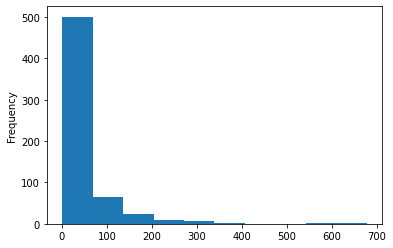

In [13]:
df['userId'].value_counts().plot(kind='hist')

Let's zoom on less that 100 ratings per user

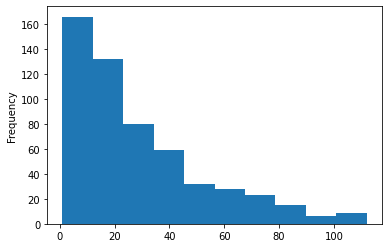

In [64]:
df['userId'].value_counts()[-550:].plot(kind='hist')

# Modeling

We will run two different matrix factorization models/packages with 4 different minimum of rating per user. Then we will chose our best option. Finally, we will hypertune the parameters of this best option.

In [8]:
df['count']=df['userId'].map(df['userId'].value_counts())
df = df.rename(columns={"userId":"user_id", "movieId":"item_id"})
df_10 = df[df['count']>10]
df_5 = df[df['count']>5]
df_50 = df[df['count']>50]
df_20 = df[df['count']>20]

## Min 10 ratings

### Matrix factorization

In [9]:
X = df_10[['user_id','item_id']]
y = df_10['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_10['user_id'])

In [10]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0083996455713902
Epoch  2 / 200  -  train_rmse: 0.9846074455618368
Epoch  3 / 200  -  train_rmse: 0.9658749999956936
Epoch  4 / 200  -  train_rmse: 0.950431725724864
Epoch  5 / 200  -  train_rmse: 0.937403796769232
Epoch  6 / 200  -  train_rmse: 0.9261483028274611
Epoch  7 / 200  -  train_rmse: 0.9162938427004327
Epoch  8 / 200  -  train_rmse: 0.9075056730160458
Epoch  9 / 200  -  train_rmse: 0.899600592816097
Epoch  10 / 200  -  train_rmse: 0.892406563444301
Epoch  11 / 200  -  train_rmse: 0.8858089666492973
Epoch  12 / 200  -  train_rmse: 0.8796989756120966
Epoch  13 / 200  -  train_rmse: 0.8740107591133637
Epoch  14 / 200  -  train_rmse: 0.8686824121113746
Epoch  15 / 200  -  train_rmse: 0.863658972356959
Epoch  16 / 200  -  train_rmse: 0.8589072165525463
Epoch  17 / 200  -  train_rmse: 0.8543910297842382
Epoch  18 / 200  -  train_rmse: 0.8500803157548745
Epoch  19 / 200  -  train_rmse: 0.845955463519669
Epoch  20 / 200  -  train_rmse: 0.841994858736

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [11]:
# matrix_fact.update_users(X_train_update, y_train_update, lr=0.001, n_epochs=200, verbose=1)

In [12]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_10 = (rmse, r2)
metrics_mf_10

(0.893606057972719, 0.2638699475491928)

### SVD

In [13]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [14]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [15]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (1.0109925270080566,
  0.9993000030517578,
  0.9973728656768799,
  0.9891788959503174,
  0.9889564514160156),
 'test_mae': array([0.66185961, 0.68497406, 0.68172975, 0.66989094, 0.68566594]),
 'test_rmse': array([0.85550194, 0.88168471, 0.88475818, 0.86288724, 0.89023243]),
 'test_time': (0.028723478317260742,
  0.02799201011657715,
  0.032796382904052734,
  0.028343677520751953,
  0.03338980674743652)}

In [16]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [17]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_10 = (rmse, r2)
metrics_svd_10

(0.8745701400322375, 0.2948985134548048)

## Min 5 ratings
### Matrix factorization

In [18]:
X = df_5[['user_id','item_id']]
y = df_5['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_5['user_id'])

In [19]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0177491832759407
Epoch  2 / 200  -  train_rmse: 0.9936167953730801
Epoch  3 / 200  -  train_rmse: 0.9745322141972046
Epoch  4 / 200  -  train_rmse: 0.958900188911406
Epoch  5 / 200  -  train_rmse: 0.9457165245736395
Epoch  6 / 200  -  train_rmse: 0.9343441781182534
Epoch  7 / 200  -  train_rmse: 0.9243823902054759
Epoch  8 / 200  -  train_rmse: 0.9155244249401804
Epoch  9 / 200  -  train_rmse: 0.9075574041716852
Epoch  10 / 200  -  train_rmse: 0.9003013193620195
Epoch  11 / 200  -  train_rmse: 0.8936373424902603
Epoch  12 / 200  -  train_rmse: 0.8874773116178144
Epoch  13 / 200  -  train_rmse: 0.8817388451719443
Epoch  14 / 200  -  train_rmse: 0.876362682031444
Epoch  15 / 200  -  train_rmse: 0.8712931185426828
Epoch  16 / 200  -  train_rmse: 0.8664942646658477
Epoch  17 / 200  -  train_rmse: 0.8619293002574633
Epoch  18 / 200  -  train_rmse: 0.8575731066627162
Epoch  19 / 200  -  train_rmse: 0.8534003391926251
Epoch  20 / 200  -  train_rmse: 0.84939178

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [20]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_5 = (rmse, r2)
metrics_mf_5

(0.8899864162010342, 0.24143013028929972)

### SVD

In [21]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [22]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [23]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (1.0458879470825195,
  1.034822940826416,
  1.0393955707550049,
  1.0471115112304688,
  1.0533277988433838),
 'test_mae': array([0.6945897 , 0.68101093, 0.68496597, 0.67515288, 0.66589902]),
 'test_rmse': array([0.89265219, 0.88394651, 0.88469139, 0.87536258, 0.86968621]),
 'test_time': (0.028812646865844727,
  0.028341293334960938,
  0.033648014068603516,
  0.028737783432006836,
  0.04900693893432617)}

In [24]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [25]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_5 = (rmse, r2)
metrics_svd_5

(0.870252525644967, 0.27469709460737113)

## Min 50 ratings
### Matrix factorization

In [26]:
X = df_50[['user_id','item_id']]
y = df_50['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_50['user_id'])

In [27]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 0.993404890509784
Epoch  2 / 200  -  train_rmse: 0.9705016837482731
Epoch  3 / 200  -  train_rmse: 0.9523138218797927
Epoch  4 / 200  -  train_rmse: 0.9372336532505214
Epoch  5 / 200  -  train_rmse: 0.9243685959105227
Epoch  6 / 200  -  train_rmse: 0.9131575292477048
Epoch  7 / 200  -  train_rmse: 0.90326976392414
Epoch  8 / 200  -  train_rmse: 0.8944343876030495
Epoch  9 / 200  -  train_rmse: 0.8864743946506423
Epoch  10 / 200  -  train_rmse: 0.8792220654277223
Epoch  11 / 200  -  train_rmse: 0.8725708196056685
Epoch  12 / 200  -  train_rmse: 0.8664402662225955
Epoch  13 / 200  -  train_rmse: 0.8607412607476901
Epoch  14 / 200  -  train_rmse: 0.855419770482439
Epoch  15 / 200  -  train_rmse: 0.8504238312702774
Epoch  16 / 200  -  train_rmse: 0.845707085733956
Epoch  17 / 200  -  train_rmse: 0.8412372752933527
Epoch  18 / 200  -  train_rmse: 0.8369834485805208
Epoch  19 / 200  -  train_rmse: 0.8329199195583666
Epoch  20 / 200  -  train_rmse: 0.82902572074

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [28]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_50 = (rmse, r2)
metrics_mf_50

(0.8673843160992969, 0.2750386266521049)

### SVD

In [29]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [30]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [31]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (0.7181310653686523,
  0.7184791564941406,
  0.7080061435699463,
  0.7114322185516357,
  0.6997618675231934),
 'test_mae': array([0.66251144, 0.6718517 , 0.66843103, 0.65861801, 0.65997596]),
 'test_rmse': array([0.85431528, 0.86766754, 0.86396858, 0.85216745, 0.85081055]),
 'test_time': (0.019499778747558594,
  0.019063472747802734,
  0.019317626953125,
  0.02272963523864746,
  0.020193099975585938)}

In [32]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [33]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_50 = (rmse, r2)
metrics_svd_50

(0.8492274942526018, 0.3050719689548955)

## Min 20 ratings
### Matrix factorization

In [34]:
df_20 = df[df['count']>20]
X = df_20[['user_id','item_id']]
y = df_20['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

In [35]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0094679225241074
Epoch  2 / 200  -  train_rmse: 0.9859429630335019
Epoch  3 / 200  -  train_rmse: 0.9671953428567706
Epoch  4 / 200  -  train_rmse: 0.9516409565592682
Epoch  5 / 200  -  train_rmse: 0.9383903221129478
Epoch  6 / 200  -  train_rmse: 0.9268924941830223
Epoch  7 / 200  -  train_rmse: 0.9167809193556972
Epoch  8 / 200  -  train_rmse: 0.9077546926211938
Epoch  9 / 200  -  train_rmse: 0.8996252830209455
Epoch  10 / 200  -  train_rmse: 0.8922304794449697
Epoch  11 / 200  -  train_rmse: 0.8854475995734343
Epoch  12 / 200  -  train_rmse: 0.8791781859101948
Epoch  13 / 200  -  train_rmse: 0.8733442264012543
Epoch  14 / 200  -  train_rmse: 0.867889783556425
Epoch  15 / 200  -  train_rmse: 0.8627598362631125
Epoch  16 / 200  -  train_rmse: 0.8579110635044497
Epoch  17 / 200  -  train_rmse: 0.8533070854379163
Epoch  18 / 200  -  train_rmse: 0.8489220827290358
Epoch  19 / 200  -  train_rmse: 0.8447297579004713
Epoch  20 / 200  -  train_rmse: 0.8407068

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [36]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_20 = (rmse, r2)
metrics_mf_20

(0.8866999837639745, 0.26521648087153316)

### SVD

In [37]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [38]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [39]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (0.9646100997924805,
  0.9506909847259521,
  0.9288296699523926,
  0.9290697574615479,
  0.9350330829620361),
 'test_mae': array([0.674097  , 0.66459188, 0.68550958, 0.67665807, 0.67482603]),
 'test_rmse': array([0.87214823, 0.86047951, 0.88846063, 0.87810712, 0.86965017]),
 'test_time': (0.02562713623046875,
  0.03073406219482422,
  0.02535843849182129,
  0.026038408279418945,
  0.025626659393310547)}

In [40]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [41]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_20 = (rmse, r2)
metrics_svd_20

(0.8710343443958191, 0.29095048491052844)

## Model Selection

In [42]:
mins = [5,5,10,10,50,50,20,20]
methods = [0,1,0,1,0,1,0,1]
metrics = [metrics_mf_5,metrics_svd_5,metrics_mf_10, metrics_svd_10, metrics_mf_50, metrics_svd_50,metrics_mf_20, metrics_svd_20 ]
rmses = []
r2s = []
for met in metrics:
  rmses.append(met[0])
  r2s.append(met[1])

In [49]:
rmses

[0.8874538602069754,
 0.8681151628159886,
 0.8950978955531211,
 0.8720290051297501,
 0.8759059646560083,
 0.8509081934112404,
 0.8969691818247627,
 0.8721512945324089]

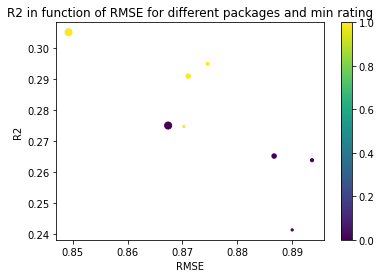

In [44]:
plt.scatter(x=rmses, y=r2s, s=mins, c=methods)
plt.xlabel('RMSE')
plt.ylabel('R2')
plt.title('R2 in function of RMSE for different packages and min rating')
plt.colorbar()
plt.show()

We want to maximize R2 and minimize RMSE. So we want the most left upper corner point!

First, the SVD matrix factorization - yellow points- returns better metrics, we will use this package.

Concerning the minimum of rating per users, limited users with more than 50 ratings is too much, we will lose to many data. Let use the SVD model with minimum number of 20 and try to tune its hyperparameters. 

Let know hypertune the parameters of this model.

## Hyperparameters of SVD with 20 min user ratings

We will hypertune the number of factors, epochs and learning rate.

In [45]:
df_20 = df[df['count']>20]

df_train, df_test = train_test_split(df_20, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

In [46]:
factors = [100,200,500]
epochs = [20,50,100]
lr_all = [0.001,0.005,0.01]

In [47]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
rmse_20 = []
r2_20 = []
params = []
for fac in factors:
  for epoch in epochs:
    for lr in lr_all:
      svd = SVD(n_factors=fac, n_epochs=epoch, lr_all=lr)
      cross_validate(svd, data, measures=['RMSE','MAE'])
      trainset = data.build_full_trainset()
      svd.fit(trainset)
      y_pred = []
      for line in range(len(df_test)):
        y_pred.append(svd.predict(df_test.iloc[line,0],df_test.iloc[line,1],3)[3])
      rmse_20.append(mean_squared_error(df_test['rating'], y_pred, squared=False))
      r2_20.append(r2_score(df_test['rating'], y_pred))
      params.append((fac,epoch,lr))



In [53]:
np.argmin(rmse_20), np.argmax(r2_20), params[np.argmin(rmse_20)]

(26, 26, (500, 100, 0.01))

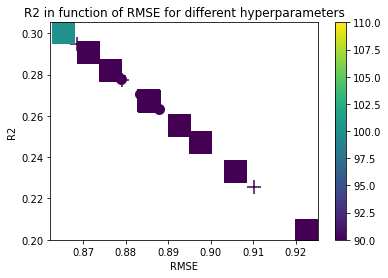

In [49]:
factors_plt = [100,100,100,100,100,100,100,100,100,200,200,200,200,200,200,200,200,200,500,500,500,500,500,500,500,500,500]
epochs_plt = [20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100]
marker_plt = ['o','o','o','o','o','o','o','o','o','+','+','+','+','+','+','+','+','+','s','s','s','s','s','s','s','s','s']
for _m, c, _s, _x, _y in zip(marker_plt, epochs_plt, factors_plt, rmse_20, r2_20):
    plt.scatter(_x, _y, marker=_m, c=c, s=_s)
# plt.scatter(x=rmse_20, y=r2_20, s=factors_plt, c=epochs_plt, marker=marker_plt)
plt.xlabel('RMSE')
plt.ylabel('R2')
plt.title('R2 in function of RMSE for different hyperparameters')
plt.colorbar()
plt.show()

Again, we want to most left upper point. The best option is the default one: n_factors=500, epochs=100 and learning rate=0.01

## Get 10 best reco

In [67]:
df_20 = df[df['count']>20]

df_train, df_test = train_test_split(df_20, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
svd = SVD(n_factors=500, n_epochs=100, lr_all=0.01)
cross_validate(svd, data, measures=['RMSE','MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)

In [80]:
def get_10(user_id, top_n=10):
  movies_id = df_20['item_id'].unique().tolist()
  movie_rates = [(id, svd.predict(user_id, id)[3]) for id in movies_id]#
  movie_rates = sorted(movie_rates, key=lambda x:x[1], reverse=True)
  return dict(movie_rates[:top_n])



In [81]:
get_10(1)

{475: 5,
 745: 5,
 750: 4.991575260118308,
 923: 5,
 924: 4.998327374974078,
 1250: 4.983823533247983,
 1278: 5,
 2067: 5,
 2502: 5,
 8874: 5}